# 作业1

在这次作业中，我们将尝试提取基本的图像特征并使用提取的特征进行图像分类。  

__你需要在TODO模块的 `"""你的代码""" `中填写相应的代码。__

你也可以添加任意数量的 cell 来辅助你完成实验。

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from past.builtins import xrange
%matplotlib inline
plt.rcParams['figure.figsize'] = (15., 12.) # 设置默认大小
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

## 数据加载

理解该数据集的类型以及访问方式

In [2]:
# 读取提供的cifar10-mini数据集，
data = np.load('cifar10-mini.npz')

X_train= data['X_train']
X_val= data['X_val']
X_test= data['X_test']

y_train= data['y_train']
y_val= data['y_val']
y_test= data['y_test']

# 打印数据shape
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(5000, 32, 32, 3)
(500, 32, 32, 3)
(500, 32, 32, 3)


(32, 32, 3)


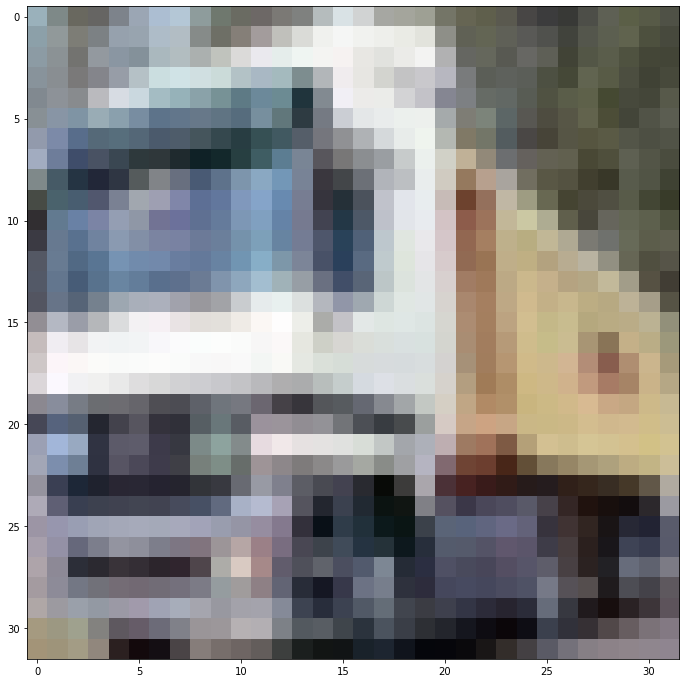

In [3]:
# 查看数据集图像
pic_index = 1 #第几张图片
print(X_train[pic_index].shape)
plt.imshow(X_train[pic_index].astype(int))

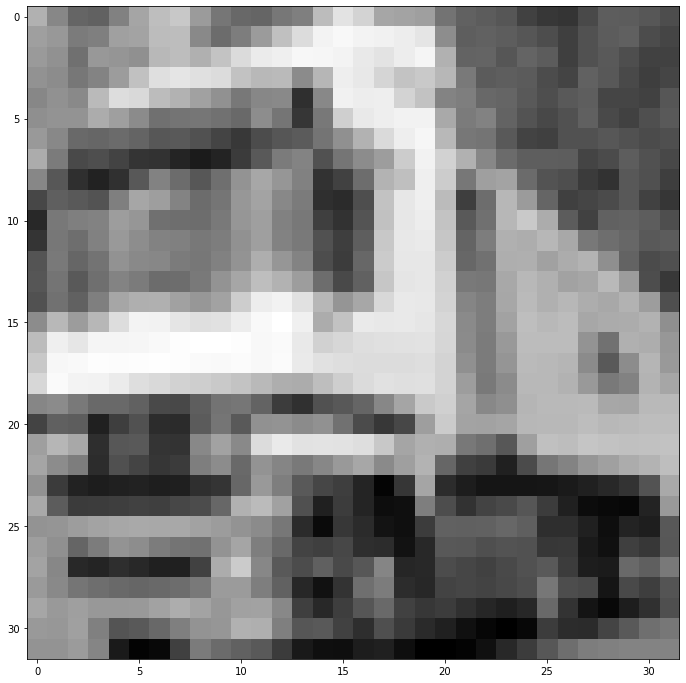

In [15]:
demo_img = X_train[pic_index]
channel_id = 1
black_demo = demo_img[:,:,channel_id]
plt.imshow(black_demo)


## 提取图像特征
[方向梯度直方图 HOG (Histogram of Oriented Gridients)](http://blog.csdn.net/zouxy09/article/details/7929348)特征检测算法，最早是由法国研究员Dalal等在CVPR-2005上提出来的，一种解决人体目标检测的图像描述子，是一种用于表征图像局部梯度方向和梯度强度分布特性的描述符。其主要思想是：在边缘具体位置未知的情况下，边缘方向的分布也可以很好的表示图像中物体的外形轮廓，但会忽略掉颜色信息。特征维度是144维

[颜色直方图 (color histogram)](https://baike.baidu.com/item/颜色直方图)特征则是提取图像的颜色信息并忽略掉纹理信息。因此同时使用这两种特征的分类效果会好于仅使用单一特征，__【加分项】你可以尝试进行对比实验验证这一假设__

`hog_feature` 和 `color_histogram_hsv` 两个函数都是接收一张图像然后返回这张图像的特征向量。你可以使用这两个函数中的一个提取所有图像的特征并将其存入 `X_train_feats, X_val_feats, X_test_feats` 这三个变量中（他们分别代表训练集、验证集和测试集的特征）。

如果你遇到了错误 `ImportError: No module named past.builtins`，可以在终端中执行 `pip install future`

In [3]:
from features import *

################################################################################
# TODO:                                                                        #
# 你需要使用 hog_feature, color_histogram_hsv 两个函数完成特征的提取           #
# 你可以在 features.py 中查看这两个函数的代码                                  #
################################################################################
"""你的代码"""
X_train_feats = extract_features(X_train,[hog_feature,color_histogram_hsv])
X_val_feats = extract_features(X_val,[hog_feature,color_histogram_hsv])
X_test_feats = extract_features(X_test,[hog_feature,color_histogram_hsv])

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

    
# 预处理: 减去均值
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat

mean_feat = np.mean(X_val_feats, axis=0, keepdims=True)
X_val_feats -= mean_feat

mean_feat = np.mean(X_test_feats, axis=0, keepdims=True)
X_test_feats -= mean_feat

# 预处理: 除以标准差，这能保证所有的值在 0～1 之间
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat

std_feat = np.std(X_val_feats, axis=0, keepdims=True)
X_val_feats /= std_feat

std_feat = np.std(X_test_feats, axis=0, keepdims=True)
X_test_feats /= std_feat

# 预处理: 增加一个偏置值，在 K-NN 中，该步操作并无必要，但增加偏置值对其他分类器如 SVM 等有帮助。
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

## 使用 k-NN 算法对图像进行分类

使用上面提取的特征执行 k-NN 算法对图像分类，在这里，__【加分项】你也可以实验对比使用 HOG特征、颜色直方图特征与使用图像原始特征（像素）哪个好。或者尝试特征拼接。__

这里你需要补全`KNearestNeighbor`类中的部分关键函数的代码，包括`compute_distances_one_loop`,`compute_distances_two_loop`,`compute_distances_no_loop`


你可能需要认真阅读玩下面两篇文章后才能完成这部分作业：

- [CS231n课程笔记翻译：图像分类笔记（上）](https://zhuanlan.zhihu.com/p/20894041?refer=intelligentunit)
- [CS231n课程笔记翻译：图像分类笔记（下）](https://zhuanlan.zhihu.com/p/20900216?refer=intelligentunit)

In [4]:
class KNearestNeighbor(object):
    """ 使用L2距离的kNN分类器 """
    def __init__(self):
        pass
    
    def train(self, X, y):
        """ 
        训练分类器 
        
        输入：
        - X: 一个形状为(num_train, D)的numpy数组，包含训练数据。
        - y: 一个形状为(num_train,)的numpy数组，包含训练标签，其中 y[i]是X[i]的标签。
        """
        self.X_train = X
        self.y_train = y
    
    def predict(self, X, k=1, num_loops=0):
        """
        使用该分类器预测测试数据的标签。
        
        输入：
        - X: 一个形状为(num_test, D)的numpy数组，包含测试数据。
        - k: 为预测标签投票的近邻的数量。
        - num_loops: 决定使用哪种方法来计算训练点和测试点之间的距离。训练点和测试点之间的距离。
        
        输出：
        - y: 一个形状为(num_test,)的numpy数组，包含测试数据的预测标签。测试数据的预测标签，其中y[i]是测试点X[i]的预测标签。
        """
        if num_loops == 0:
            dists = self.compute_distances_no_loops(X)
        elif num_loops == 1:
            dists = self.compute_distances_one_loop(X)
        elif num_loops == 2:
            dists = self.compute_distances_two_loops(X)
        else:
            raise ValueError('Invalid value %d for num_loops' % num_loops)

        return self.predict_labels(dists, k=k)

    def compute_distances_two_loops(self, X):
        """
        计算X中每个测试点和self.X_train中每个训练点之间的距离。
        需要使用一个嵌套循环。

        输入:
        - X：一个形状为(num_test, D)的numpy数组，包含测试数据。

        输出:
        - dists: 一个形状为(num_test, num_train)的numpy数组，其中dists[i, j] 是第i个测试点和第j个训练点之间的欧几里得距离。
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in xrange(num_test):
            for j in xrange(num_train):
                #####################################################################
                # TODO:                                                             #
                # 计算第i个测试点和第j个训练点之间的l2距离，并将结果存入dists[i, j]中
                #####################################################################
                """你的代码"""
                dists[i,j] = np.sqrt(np.sum(np.square(self.X_train[j,:] - X[i,:])))
                #####################################################################
                #                       END OF YOUR CODE                            #
                #####################################################################
        return dists

    def compute_distances_one_loop(self, X):
        """
        计算X中每个测试点和self.X_train中每个训练点之间的距离。
        只需在测试数据上进行一次循环。

        输入/输出。与compute_distances_two_loops相同
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in xrange(num_test):
            #######################################################################
            # TODO:                                                               #
            # 计算第i个测试点和所有训练点之间的l2距离，并将结果存入dists[i, :]中。#
            #######################################################################
            """你的代码"""
            dists[i] = np.sqrt(np.sum(np.square(self.X_train - X[i]), axis = 1))
            #######################################################################
            #                         END OF YOUR CODE                            #
            #######################################################################
        return dists

    def compute_distances_no_loops(self, X):
        """
        计算X中每个测试点和self.X_train中每个训练点之间的距离，不使用显式循环。

        输入/输出。与compute_distances_two_loops相同
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train)) 
        ##########################################################################
        # TODO:                                                                  #
        # 计算所有测试点和所有训练点之间的l2距离，不使用任何显式循环             #
        # 并将结果存储在dists中                                                  #
        ##########################################################################
        """你的代码"""
        M = np.dot(X, self.X_train.T)
        nrow = M.shape[0]
        ncol = M.shape[1]
        te = np.diag(np.dot(X, X.T))
        tr = np.diag(np.dot(self.X_train, self.X_train.T))
        te = np.reshape(np.repeat(te, ncol), M.shape)
        tr = np.reshape(np.repeat(tr, nrow), M.T.shape)
        sq = -2 * M + te + tr.T
        dists = np.sqrt(sq)
        ##########################################################################
        #                         END OF YOUR CODE                               #
        ##########################################################################
        return dists

    def predict_labels(self, dists, k=1):
        """
        给出一个测试点和训练点之间距离的矩阵。为每个测试点预测一个标签。

        输入:
        - dists: 一个形状为(num_test, num_train)的numpy数组，
        其中dists[i, j] ... 表示第i个测试点和第j个训练点之间的距离。

        输出:
        - y: 一个形状为(num_test,)的numpy数组，包含测试数据的预测标签。
        其中y[i]是测试点X[i]的预测标签。 
        """
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in xrange(num_test):
            # 一个长度为k的列表，存储第i个测试点的k个最近的邻居的标签。
            closest_y = []

            # 使用距离矩阵找到第1个测试点的k个最近的邻居，并使用self.y_train来找到这些邻居的标签。#
            # 将这些标签存储在closest_y中。                                               #
            k_nearest_idxs = np.argsort(dists[i, :])[:k]
            closest_y = self.y_train[k_nearest_idxs]
            
            # 找到标签列表closest_y中最常见的标签，将这个标签存入y_pred[i]。                                                  #
            y_pred[i] = np.argmax(np.bincount(closest_y))

        return y_pred

In [5]:
# 实例化
classifier = KNearestNeighbor()
# 训练KNN分类器
classifier.train(X_train_feats, y_train)

# 使用验证集调整 k 的值
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
k_to_accuracies = {} # 用来存储结果

##########################################################################################
# TODO:                                                                                  #
# 你需要从 k_choice 中找出最好的 k                                                       #
# 如果accuracy <= 0.1， 说明结果不对，随机猜的准确率是0.1，需要修改k_nearest_neighbor.py #
##########################################################################################

#遍历所有的k，在验证集上进行结果测试分类的准确性
for k in k_choices:
    """你的代码"""

##########################################################################################
#                                 END OF YOUR CODE                                       #
##########################################################################################

print(k_to_accuracies)

{}


In [7]:
# 评估你的算法
##########################################################################################
# TODO:                                                                                  #
# 根据验证集的结果，选择合适的K值，并在测试集上测试结果                                  #
"""你的代码"""
best_k = 12  # 填你上面选出的 K 值 
##########################################################################################
#                                 END OF YOUR CODE                                       #
##########################################################################################

# 计算测试集上准确率
y_test_pred = classifier.predict(X_test_feats, k=best_k)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.308
